In [2]:
import os
import string
import re
from pathlib import Path

In [3]:
current_dir = Path(os.getcwd()).absolute()
results_dir = current_dir.joinpath('results')
results_dir.mkdir(parents=True, exist_ok=True)
data_dir = current_dir.joinpath('data')
data_dir.mkdir(parents=True, exist_ok=True)
external_data_dir = current_dir.parent.parent.parent.joinpath('data')
imdb_dir = external_data_dir.joinpath(r'external/imdb/aclImdb')




print(current_dir)
print(results_dir)
print(data_dir)
print(imdb_dir)

c:\Users\saman\git_repos\dsc650\dsc650\assignments\assignment10
c:\Users\saman\git_repos\dsc650\dsc650\assignments\assignment10\results
c:\Users\saman\git_repos\dsc650\dsc650\assignments\assignment10\data
c:\Users\saman\git_repos\dsc650\data\external\imdb\aclImdb


#### Assignment 10.1.a  

Create a tokenize function that splits a sentence into words. Ensure that your tokenizer removes basic punctuation.

In [ ]:
file_name = "sample.txt"
file_path = f"{data_dir}\{file_name}"
file_path

In [ ]:
def tokenize(sentence):
    tokens = []
    words = sentence.split()
    # tokenize the sentence
    for word in words:
        # allowing only alphabets
        word = re.sub("[^a-zA-Z]", "", word)
        tokens.append(word)
    return tokens

In [ ]:
def call_tokenize():
    with open(f'{file_path}','r') as f:
        for line in f:
            line = line.lower()
                        
            return tokenize(line)

call_tokenize()

#### Assignment 10.1.b

Implement an `ngram` function that splits tokens into N-grams. 

In [ ]:
def ngram(tokens, n):
    # ngrams = []
    # Create ngrams
    # return ngrams
    return print(list(zip(*[tokens[i:] for i in range(n)])))

In [ ]:
def call_ngram():
    with open(f'{file_path}','r') as f:
        for line in f:
            line = line.lower()
            # print(line, end = 'XX')
            return ngram(tokenize(line),3)

call_ngram()

#### Assignment 10.1.c

Implement an one_hot_encode function to create a vector from a numerical vector from a list of tokens.

In [ ]:
def one_hot_encode(tokens, num_words):
    token_index = {}
    results = ''
    return results

#### 10.2

Using listings 6.16, 6.17, and 6.18 in Deep Learning with Python as a guide, train a sequential model with embeddings on the IMDB data found in data/external/imdb/. Produce the model performance metrics and training and validation accuracy curves within the Jupyter notebook.

In [8]:
# Processing the labels of the raw IMDB data

def load_raw_imdb(source_dir):

    labels = []
    texts = []

    for label_type in ['neg','pos']:
        dir_name = source_dir.joinpath(label_type) 
        for fname in os.listdir(dir_name):
            if fname[-4:] == '.txt':
                f = open(dir_name.joinpath(fname), encoding="utf8")
                texts.append(f.read())
                f.close()
                if label_type == 'neg':
                    labels.append(0)
                else:
                    labels.append(1)
    
    labels = np.asarray(labels)
    return texts,labels

In [9]:
# Plotting the results from the training and validation set

import matplotlib.pyplot as plt

def plot_train_val(acc,val_acc,loss, val_loss):

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    if len(val_acc) == 0:
        plt.title('Training Accuracy')
    else:
        plt.plot(epochs, val_acc, 'b', label='Validation acc')
        plt.title('Training and validation accuracy')        
        
    plt.legend()
    plt.figure()
    
    plt.plot(epochs, loss, 'bo', label='Training loss')
    if len(val_loss) == 0:
        plt.title('Training loss')
    else:
        plt.plot(epochs, val_loss, 'b', label='Validation loss')
        plt.title('Training and validation loss')        
        
    plt.legend()
    plt.show()

In [10]:
# Tokenizing the text of the raw IMDB data

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np


train_dir = imdb_dir.joinpath('train')
(texts,labels) = load_raw_imdb(train_dir)
    
# cuts off reviews after 100 words
maxlen = 100
# trains 200 samples
training_samples = 200
#validates on 10,000 samples
validation_samples = 10000
# considers only the top 10,000 words in the dataset
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Splits the data into a training set and a validation set, but first shuffles the data,
# because you’re starting with data in which samples are ordered (all negative first, then all positive)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [ ]:
# Parsing the GloVe word-embeddings file
glove_dir = '/home/jovyan/glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# Preparing the GloVe word-embeddings matrix

embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            
# Training the same model without pretrained word embeddings
# Model Definition

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()


In [ ]:
# Training and Evaluating the model

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))


#### The accuracy = 1.0

In [ ]:
#saving the model
model.save_weights('glove_model.h5')

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

plot_train_val(acc,val_acc,loss,val_loss)

In [11]:
# Tokenizing the data for the test set
test_dir = imdb_dir.joinpath('test')
(texts,labels) = load_raw_imdb(test_dir)
                
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)
print('Shape of data tensor:', x_test.shape)
print('Shape of label tensor:', y_test.shape)

Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [12]:
# Load and evaluate the model on the test set
model.load_weights('glove_model.h5')
model.evaluate(x_test, y_test)

NameError: name 'model' is not defined

In [ ]:
#### The accuracy is 53.68 / 52.34 / 55.11

In [ ]:
# Plotting the results from the test set

acc = history.history['acc']
loss = history.history['loss']
val_acc = []
val_loss = []

plot_train_val(acc,val_acc,loss,val_loss)

#### 10.3
Using listing 6.27 in Deep Learning with Python as a guide, fit the same data with an LSTM layer. Produce the model performance metrics and training and validation accuracy curves within the Jupyter notebook.

In [13]:
# Processing the labels of the raw IMDB data
train_dir = imdb_dir.joinpath('train')
print('Loading Training data...')
 
(input_train, y_train) = load_raw_imdb(train_dir)
print(len(input_train), 'train sequences')

test_dir = imdb_dir.joinpath('test')
print('Loading Test data...')
 
(input_test, y_test) = load_raw_imdb(test_dir)
print(len(input_test), 'test sequences')

Loading Training data...
25000 train sequences
Loading Test data...
25000 test sequences


In [14]:
# Using the same train and test data set from the above dataset
# Preparing the dataset differently
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

# Number of words to consider in the features
max_features = 10000
# Cuts off texts after this many words 
# (among the max_features most common words)
maxlen = 500
batch_size = 32

train_dir = imdb_dir.joinpath('train')
test_dir = imdb_dir.joinpath('test')
print('Loading data...')
(input_train, y_train) =  load_raw_imdb(train_dir)
(input_test, y_test) = load_raw_imdb(test_dir)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

tokenizer = Tokenizer(num_words=max_features)

print('Pad sequences (samples x time)')
tokenizer.fit_on_texts(input_train)
sequences = tokenizer.texts_to_sequences(input_train)
input_train = sequence.pad_sequences(sequences, maxlen=maxlen)

tokenizer.fit_on_texts(input_test)
sequences = tokenizer.texts_to_sequences(input_test)
input_test = sequence.pad_sequences(sequences, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


In [16]:
# Using LSTM layers in keras
# Model summary

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Training and evaluating the model

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

C:\Users\saman\.conda\envs\dsc650\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 55s 3ms/step - loss: 0.5026 - acc: 0.7732 - val_loss: 0.5226 - val_acc: 0.8580
Epoch 2/10
20000/20000 [==============================] - 57s 3ms/step - loss: 0.2914 - acc: 0.8896 - val_loss: 1.3560 - val_acc: 0.5352
Epoch 3/10
20000/20000 [==============================] - 59s 3ms/step - loss: 0.2187 - acc: 0.9186 - val_loss: 0.8103 - val_acc: 0.6958
Epoch 4/10
20000/20000 [==============================] - 57s 3ms/step - loss: 0.1843 - acc: 0.9348 - val_loss: 0.7733 - val_acc: 0.6928
Epoch 5/10
20000/20000 [==============================] - 58s 3ms/step - loss: 0.1608 - acc: 0.9427 - val_loss: 1.2043 - val_acc: 0.6008
Epoch 6/10
20000/20000 [==============================] - 60s 3ms/step - loss: 0.1409 - acc: 0.9513 - val_loss: 1.4721 - val_acc: 0.5418
Epoch 7/10
20000/20000 [==============================] - 59s 3ms/step - loss: 0.1325 - acc: 0.9562 - val_loss: 0.5681 - val_acc:

#### Accuracy = 96.63 / 96.55

In [18]:
#saving the model
model.save_weights('LSTM_model.h5')

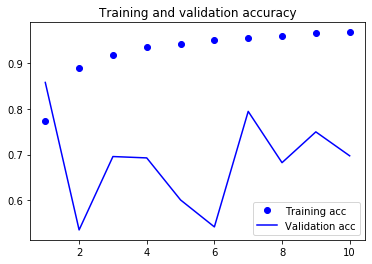

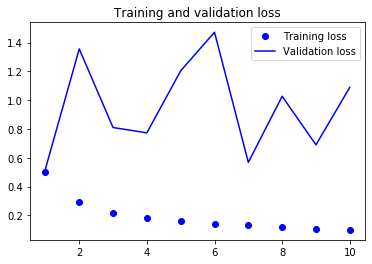

In [19]:
# Plotting the results from Training and validation accurary

acc = history.history['acc']
loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']

plot_train_val(acc,val_acc,loss,val_loss)

#### 10.4
Using listing 6.46 in Deep Learning with Python as a guide, fit the same data with a simple 1D convnet. Produce the model performance metrics and training and validation accuracy curves within the Jupyter notebook.

In [23]:
# Defining a model with simple 1D convnet on the same IMDB raw data

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=maxlen))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
____________________________________________

In [26]:
# Training and evaluating the model

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

C:\Users\saman\.conda\envs\dsc650\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 30s 2ms/step - loss: 0.6600 - acc: 0.6250 - val_loss: 0.9812 - val_acc: 0.0000e+00
Epoch 2/10
20000/20000 [==============================] - 33s 2ms/step - loss: 0.6529 - acc: 0.6250 - val_loss: 0.9460 - val_acc: 0.0000e+00
Epoch 3/10
20000/20000 [==============================] - 34s 2ms/step - loss: 0.6295 - acc: 0.6258 - val_loss: 0.8959 - val_acc: 0.0166
Epoch 4/10
20000/20000 [==============================] - 34s 2ms/step - loss: 0.5544 - acc: 0.7199 - val_loss: 0.7005 - val_acc: 0.5522
Epoch 5/10
20000/20000 [==============================] - 34s 2ms/step - loss: 0.4337 - acc: 0.8341 - val_loss: 0.5967 - val_acc: 0.6944
Epoch 6/10
20000/20000 [==============================] - 34s 2ms/step - loss: 0.3391 - acc: 0.8699 - val_loss: 0.6219 - val_acc: 0.6836
Epoch 7/10
20000/20000 [==============================] - 34s 2ms/step - loss: 0.2850 - acc: 0.8905 - val_loss: 0.5031 - 

In [27]:
#saving the model
model.save_weights('Conv1D_model.h5')

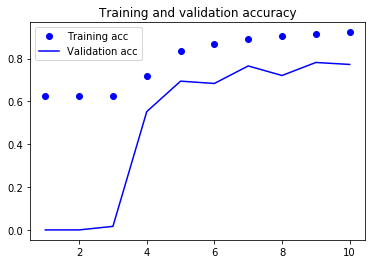

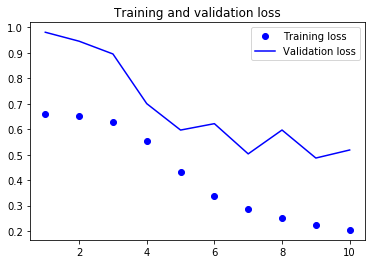

In [28]:
# Plotting the results from Training and validation accurary

acc = history.history['acc']
loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']

plot_train_val(acc,val_acc,loss,val_loss)